In [1]:
import os
import pyranges as pr
import numpy as np
import pandas as pd
import polars as pl
import scanpy as sc
import scipy
import torch
import tqdm
from accelerate import Accelerator
from matplotlib import pyplot as plt
import pickle
from trackplot.plot import Plot
from peft import LoraConfig, get_peft_model

from torch.utils.data import DataLoader

from polya_project.data import GenomeIntervalDataset

from scooby.utils.utils import fix_rev_comp_multiome, undo_squashed_scale, get_gene_slice_and_strand, get_cell_profile_pred
from scooby.utils.plotting import region_to_bin, plot_tracks, add_heatmap_to_axes
from scooby.modeling import Scooby
from scooby.data import onTheFlyMultiomeDataset 

In [ ]:
data_path = 'tmp'

In [2]:
def predict(model, seqs, seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None):
    bs = seqs.shape[0]
    assert bs == 1
    with torch.no_grad():
        with torch.autocast("cuda"):
            outputs = model.forward_sequence_w_convs(seqs, conv_weights, conv_biases, bins_to_predict = bins_to_predict)
            if bins_to_predict is not None:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = (6143 - bins_to_predict))
            else:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None)
    flipped_version = torch.flip(outputs_rev_comp,(1,-3))
    outputs_rev_comp = fix_rev_comp_multiome(flipped_version) #fix_rev_comp2(flipped_version)
    #outputs_rev_comp = fix_rev_comp2(flipped_version) #fix_rev_comp2(flipped_version)
    return (outputs + outputs_rev_comp)/2

In [3]:
accelerator = Accelerator(step_scheduler_with_optimizer = False)
csb = Scooby.from_pretrained('johahi/neurips-scooby', cell_emb_dim = 14, n_tracks = 3, use_transform_borzoi_emb = True)
csb = accelerator.prepare(csb)
clip_soft = 5

2024-09-16 15:29:05 - WARNING - Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [4]:
gtf_file = os.path.join(data_path, "gencode.v32.annotation.sorted.gtf.gz")
fasta_file = os.path.join(data_path, 'genome_human.fa')
bed_file = os.path.join(data_path, 'sequences.bed')

In [5]:
base_path = os.path.join(data_path, 'snapatac', 'pseudobulks_fixed/')

In [6]:
sample = 'merged'
with open(os.path.join(data_path, 'gencode.v32.annotation.gtf.transcriptome'), 'rb') as handle:
    transcriptome = pickle.load(handle)
neighbors = scipy.sparse.load_npz(os.path.join(data_path, 'borzoi_training_data_fixed', 'no_neighbors.npz'))
neighbors_100 = scipy.sparse.load_npz(os.path.join(data_path, 'borzoi_training_data_fixed', 'neighbors_100_no_val_genes_new.npz'))
embedding = pd.read_parquet(os.path.join(data_path, 'borzoi_training_data_fixed',  'embedding_no_val_genes_new.pq'))

In [7]:
adatas = {
    'rna_plus': sc.read(
        os.path.join(data_path, 'snapatac', 'anndata', f'snapatac_merged_fixed_plus.h5ad')
    ),
    'rna_minus': sc.read(
        os.path.join(data_path, 'snapatac', 'anndata',  f'snapatac_merged_fixed_minus.h5ad'))
    ,
    'atac': sc.read(
       os.path.join(data_path, 'snapatac', 'anndata', f'snapatac_merged_fixed_atac.h5ad')
    ),
}

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
adata = sc.read(
    os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed.h5ad'))

# read in ATAC peaks
atac_peaks = pr.PyRanges(pd.read_csv(os.path.join(data_path, 'borzoi_training_data', 'atac_peaks.csv'), index_col=0))

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


## Panel B

In [9]:
size=15
params = {'legend.fontsize': 'large',
          'font.family': 'sans-serif',
          'figure.figsize': (6,6),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75}
plt.rcParams.update(params)

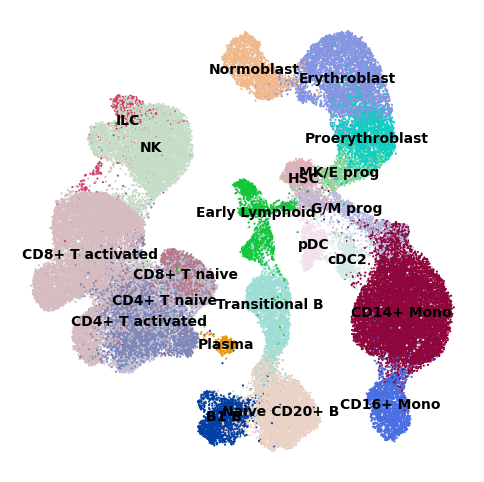

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
sc.pl.umap(adata, color='l2_cell_type', size=10, frameon=False, title="", legend_loc='on data', legend_fontweight=600, ax=ax)
ax.figure.set_dpi(300)
#fig.savefig('figures/Figure1/bone_marrow_umap.png')

## Panel B

In [11]:
# cell 1

In [11]:
cell = adata[adata.obs.l2_cell_type == 'Erythroblast'].obs_names.to_series().sample(1, random_state=0).values 

In [12]:
cell_idx_1 = np.where(adata.obs_names.isin(cell))[0].item()

In [13]:
cell_neighbor_ids = neighbors_100[cell_idx_1].nonzero()[1]
neighbors_to_load_1 = [cell_idx_1] + cell_neighbor_ids.tolist() 

In [14]:
adata.obs['test'] = adata.obs_names.isin(adata.obs_names[neighbors_to_load_1]).astype(str)

... storing 'test' as categorical


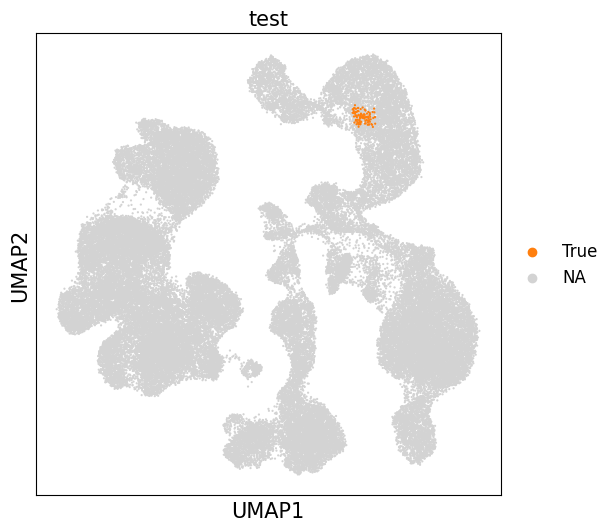

In [15]:
sc.pl.umap(adata, color='test', groups="True", size=10)

In [16]:
# cell 2

In [17]:
cell = adata[adata.obs.l2_cell_type == 'MK/E prog'].obs_names.to_series().sample(1, random_state=2).values 


In [18]:
cell_idx_2 = np.where(adata.obs_names.isin(cell))[0].item()

In [19]:
cell_neighbor_ids = neighbors_100[cell_idx_2].nonzero()[1]
neighbors_to_load_2 = [cell_idx_2] + cell_neighbor_ids.tolist() 

In [20]:
adata.obs['test'] = adata.obs_names.isin(adata.obs_names[neighbors_to_load_2]).astype(str)

... storing 'test' as categorical


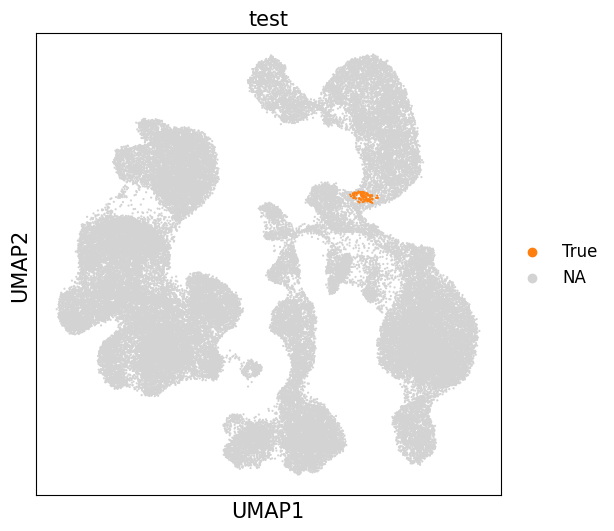

In [21]:
sc.pl.umap(adata, color='test', groups="True", size=10)

In [22]:
neighbors_to_load = neighbors_to_load_1 + neighbors_to_load_2

In [23]:
embedding_cell = torch.from_numpy(
            np.vstack(
                embedding.iloc[neighbors_to_load]['embedding'].values # gets embeddings of all cells of the cell type
                )
            ).cuda()

In [24]:
context_length = 524288
gene = "SLC25A37"
filter_val = lambda df: df.filter(pl.col('column_4').is_in([gene]))#
val_ds = GenomeIntervalDataset(
    bed_file = os.path.join(data_path,'borzoi_training_data_fixed', 'val_test_gene_sequences.csv'), 
    fasta_file = fasta_file,
    filter_df_fn = filter_val, 
    return_seq_indices = False,
    shift_augs = (0,0),
    rc_aug = False,
    return_augs = True,
    context_length = context_length,
    chr_bed_to_fasta_map = {}
)
len(val_ds)

1

In [25]:
val_dataset = onTheFlyMultiomeDataset(
    adatas=adatas,
    neighbors=neighbors,
    embedding=embedding,
    ds = val_ds, 
    clip_soft=5,
    cells_to_run=neighbors_to_load, 
    random_cells=False, 
    normalize_atac=True
)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers = 0)
csb, val_loader = accelerator.prepare(csb, val_loader)

In [26]:
all_outputs_rna, all_outputs_atac, all_targets_rna, all_targets_atac = [], [], [], []

csb.eval()
# iterate over all val gene sequences
for i,x in tqdm.tqdm(enumerate(val_loader), disable = False, total=len(val_dataset)):   
    gene_slice, strand = get_gene_slice_and_strand(
        transcriptome, val_dataset.genome_ds.df[i, 'column_4'], val_dataset.genome_ds.df[i, 'column_2'], False
    )
    bs = x[0].shape[0]
    seqs = x[0].cuda().permute(0,2,1)
    seqs_rev_comp =  torch.flip(seqs.permute(0,2,1), (-1, -2)).permute(0,2,1)
    stacked_outputs_rna, stacked_outputs_atac, stacked_counts_outputs_rna = [], [], []

    # go over embeddings for all cells of a cell type, sum the unsquashed predictions
    outputs = get_cell_profile_pred(csb, seqs, embedding_cell, predict, clip_soft=clip_soft, model_type='multiome', num_neighbors=1, chunk_size=70000)

    all_outputs_rna.append(outputs[0].detach().clone().cpu() if strand == '+' else outputs[1].detach().clone().cpu() ) 
    all_outputs_atac.append(outputs[2].detach().clone().cpu()) 
    
    targets = x[2].float().cuda()
    # get RNA:
    targets_rna = targets[:,:,torch.tensor([1,1,0]).repeat(targets.shape[2]//3).bool()]
    targets_rna = targets_rna.float().detach()

    num_pos = targets_rna.shape[-1]
    # get ATAC:
    targets_atac = targets[:,:,torch.tensor([0,0,1]).repeat(targets.shape[2]//3).bool()]
    targets_atac = targets_atac.float().detach()
    if strand == '+':
        all_targets_rna.append(undo_squashed_scale(targets_rna[0, :, :num_pos:2], clip_soft=5).detach().clone().cpu().T)
    elif strand == '-':
        all_targets_rna.append(undo_squashed_scale(targets_rna[0, :, 1:num_pos:2], clip_soft=5).detach().clone().cpu().T)

    all_targets_atac.append(targets_atac[0].detach().clone().cpu().T)
    
all_outputs_rna, all_outputs_atac = torch.stack(all_outputs_rna, axis=0).clone().numpy(force=True), torch.stack(all_outputs_atac, axis=0).clone().numpy(force=True) 
all_targets_rna, all_targets_atac = torch.stack(all_targets_rna, axis=0).clone().numpy(force=True), torch.stack(all_targets_atac, axis=0).clone().numpy(force=True)

100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


In [27]:
i=np.where(val_ds.df['column_4'] ==  gene)[0].item()

In [28]:
gtf = pr.read_gtf(gtf_file)

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
2024-09-16 15:35:23.719 | INFO     | trackplot.plot:__init__:209 - Create trackplot version: 0.4.0
2024-09-16 15:35:23.721 | INFO     | trackplot.plot:set_region:265 - set region to chr8:23480945-23581841:+


SLC25A37


2024-09-16 15:35:35.518 | INFO     | trackplot.plot:set_annotation:434 - set annotation file to /data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/gencode.v32.annotation.sorted.gtf.gz
2024-09-16 15:35:35.566 | INFO     | trackplot.plot:plot:1093 - load annotation
2024-09-16 15:35:35.622 | INFO     | trackplot.plot:plot:1107 - load data of 0 plots
2024-09-16 15:35:35.622 | DEBUG    | trackplot.plot:plot:1159 - plots n_rows=21; n_cols = 1
2024-09-16 15:35:35.623 | INFO     | trackplot.plot:plot:1160 - init graph_coords
2024-09-16 15:35:35.703 | INFO     | trackplot.plot:plot:1328 - plotting x-axis ticks at idx: 0 with height_ratio: 1
2024-09-16 15:35:35.704 | INFO     | trackplot.plot:plot:1338 - plotting annotation at idx: 0 with height_ratio: 1


1.0


2024-09-16 15:35:36.687 | INFO     | trackplot.plot:__init__:209 - Create trackplot version: 0.4.0
2024-09-16 15:35:36.689 | INFO     | trackplot.plot:set_region:265 - set region to chr8:23480945-23581841:+
2024-09-16 15:35:48.236 | INFO     | trackplot.plot:set_annotation:434 - set annotation file to /data/ceph/hdd/project/node_08/QNA/scborzoi/neurips_bone_marrow/gencode.v32.annotation.sorted.gtf.gz
2024-09-16 15:35:48.282 | INFO     | trackplot.plot:plot:1093 - load annotation
2024-09-16 15:35:48.289 | INFO     | trackplot.plot:plot:1107 - load data of 0 plots
2024-09-16 15:35:48.290 | DEBUG    | trackplot.plot:plot:1159 - plots n_rows=21; n_cols = 1
2024-09-16 15:35:48.290 | INFO     | trackplot.plot:plot:1160 - init graph_coords
2024-09-16 15:35:48.370 | INFO     | trackplot.plot:plot:1328 - plotting x-axis ticks at idx: 0 with height_ratio: 1
2024-09-16 15:35:48.371 | INFO     | trackplot.plot:plot:1338 - plotting annotation at idx: 0 with height_ratio: 1


1.0


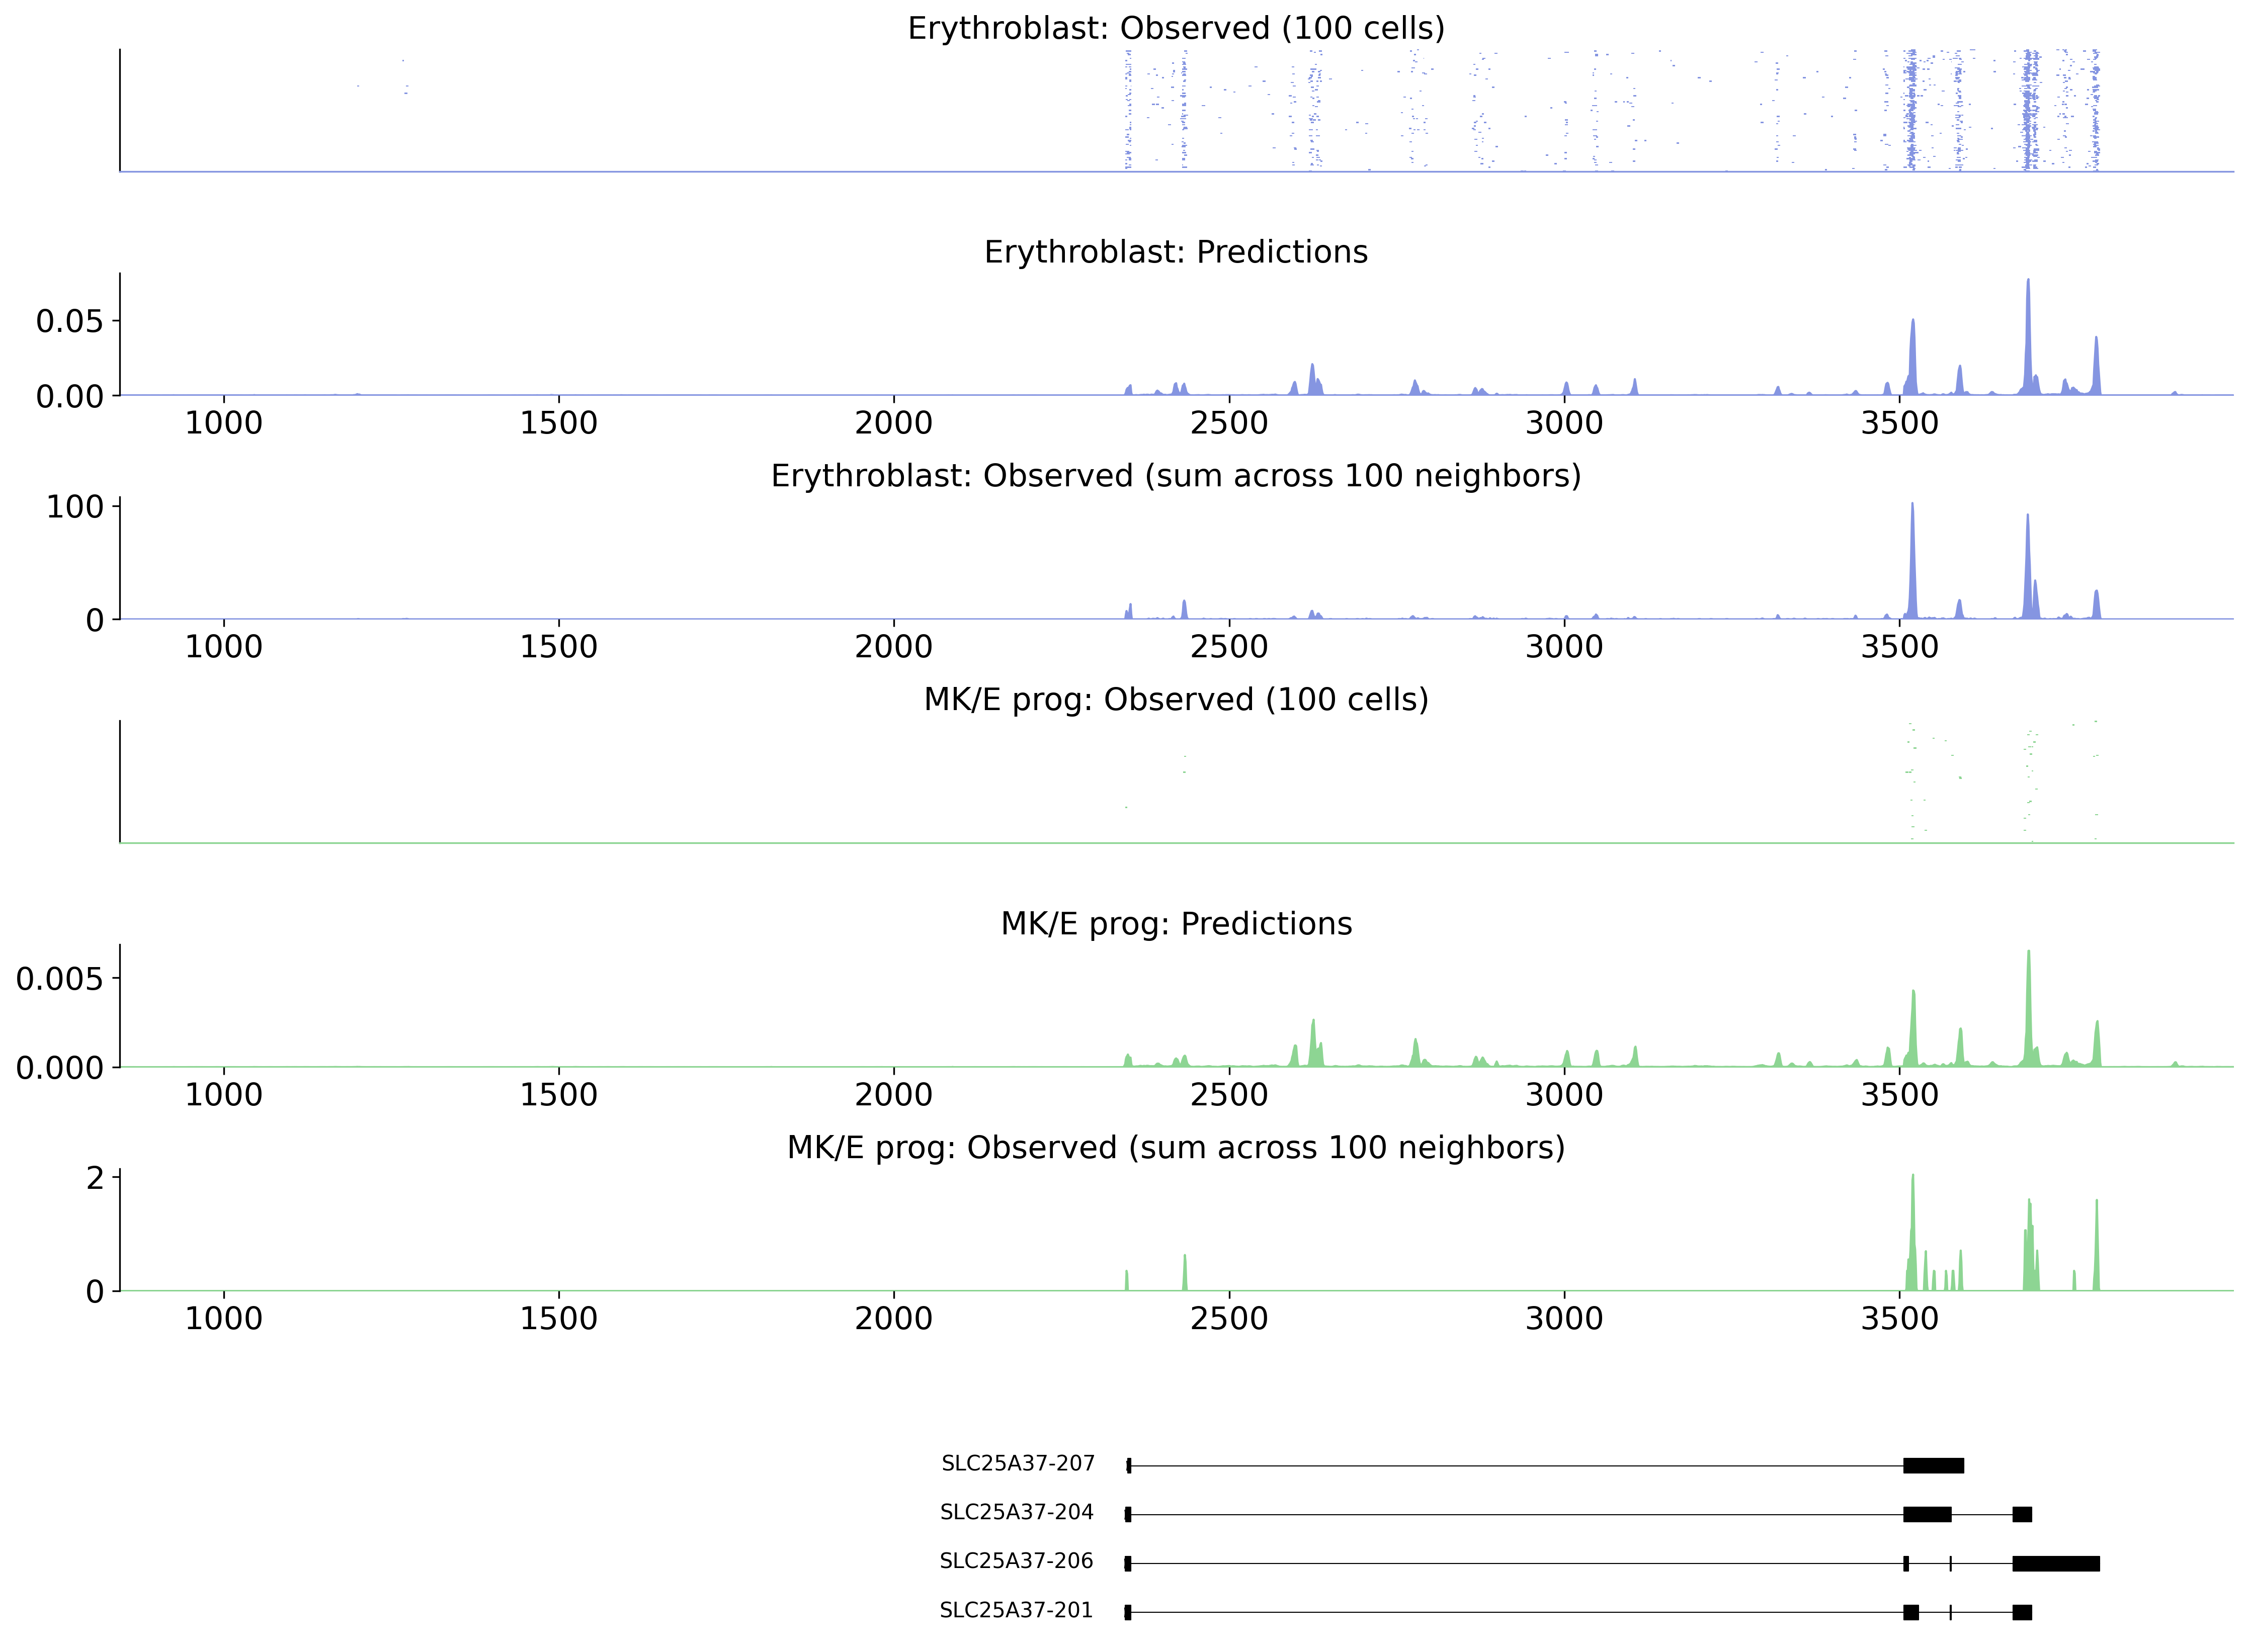

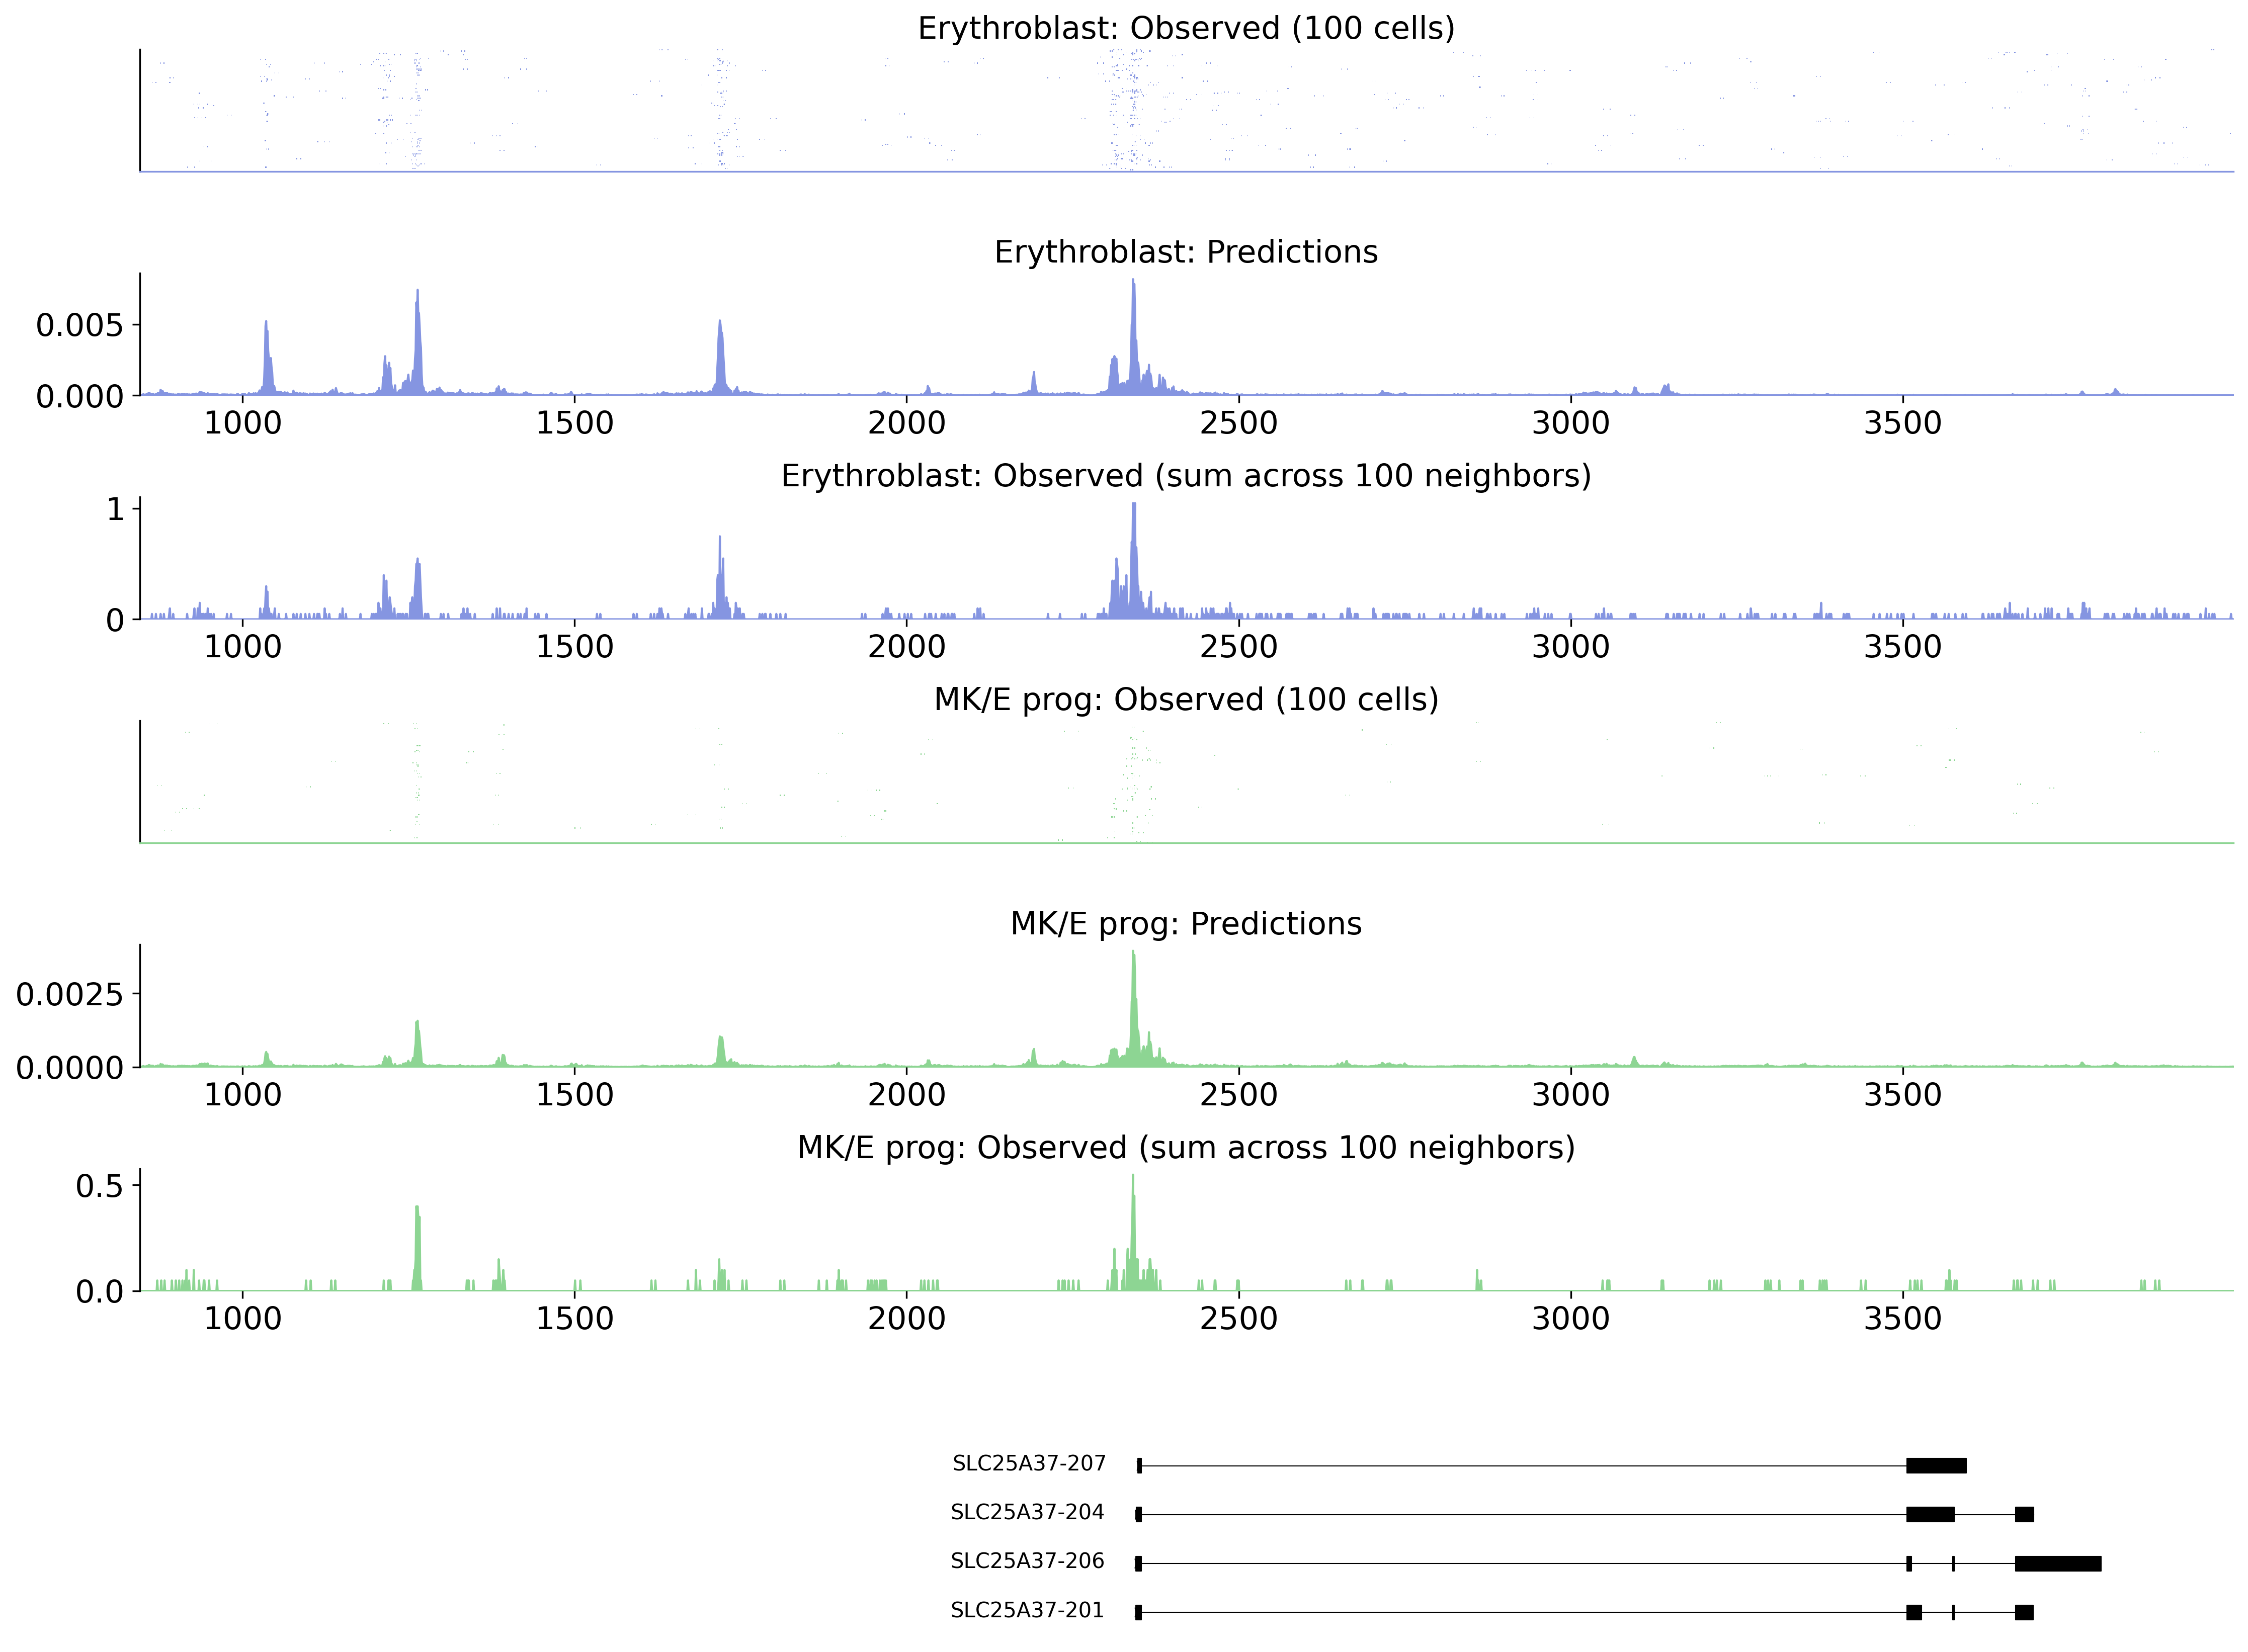

In [30]:

size=15
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 5}
plt.rcParams.update(params)


print(val_dataset.genome_ds.df[i, 'column_4'])
gene = val_dataset.genome_ds.df[i, 'column_4']

# Get gene range
gene_slice, strand = get_gene_slice_and_strand(
        transcriptome, val_dataset.genome_ds.df[i, 'column_4'], val_dataset.genome_ds.df[i, 'column_2'], False
    )

# Get exons
exons = transcriptome.genes[
    gene
    ].output_slice(
        val_dataset.genome_ds.df[i, 'column_2'],
        6144*32,
        32,
        span=False,
        sliced=False
        ) 

# Get peaks
region = val_dataset.genome_ds.df[i].to_pandas()
region.columns = ['Chromosome', 'Start', 'End', 'Gene Name', 'Strand']
region = pr.PyRanges(region)
region_peaks = atac_peaks.overlap(region).df
region_peaks = region_to_bin(region_peaks.Start, region_peaks.End, val_dataset.genome_ds.df[i, 'column_2'], 6144*32, 32 )



loffset=1500
roffset=200
interval = (np.max([gene_slice.min()-loffset, 0]), gene_slice.max()+roffset)


# Get color map
color_map = dict(zip(adata.obs.l2_cell_type.cat.categories, adata.uns['l2_cell_type_colors']))
cell_type_1 = adata[cell_idx_1].obs.l2_cell_type.astype(str)
cell_type_2 = adata[cell_idx_2].obs.l2_cell_type.astype(str)


#ylim atac
ylim_atac = all_targets_atac[i, [0, 101], interval[0]: interval[1]].max() 
ylim_atac_100 = all_targets_atac[i, :, interval[0]: interval[1]].sum(axis=0).max()
ylim_atac_out = all_outputs_atac[i, [0,101], interval[0]: interval[1]].max()

#ylim rna
ylim_rna = all_targets_rna[i, [0, 101], interval[0]: interval[1]].max() 
ylim_rna_100 = all_targets_rna[i, :, interval[0]: interval[1]].sum(axis=0).max() 
ylim_rna_out = all_outputs_rna[i, [0, 101], interval[0]: interval[1]].max() 


## RNA cell 1
tracks_targets_rna_1 = list(
    zip(
         cell_type_1 + ': Observed (one cell)', 
        all_targets_rna[i, [0]], 
        np.repeat('coverage', 1),
        (0, ylim_rna)
    ))

tracks_targets_rna_100_1 = list(
    zip(
         cell_type_1 + ': Observed (sum across 100 neighbors)', 
        all_targets_rna[i, 0:101].sum(axis=0, keepdims=True) , 
        np.repeat('coverage', 1),
        (0, ylim_rna_100)
    ))

tracks_outputs_rna_1 = list(
    zip(
        cell_type_1 + ': Predictions', 
        all_outputs_rna[i, [0]]  ,
        np.repeat('coverage', 1),
        (0, ylim_rna_out),
    ))

## RNA cell 2

tracks_targets_rna_2 = list(
    zip(
         cell_type_2 + ': Observed (one cell)', 
        all_targets_rna[i, [101]], 
        np.repeat('coverage', 1),
        (0, ylim_rna)))

tracks_targets_rna_100_2 = list(
    zip(
         cell_type_2 + ': Observed (sum across 100 neighbors)', 
        all_targets_rna[i, 101:202].sum(axis=0, keepdims=True) , 
        np.repeat('coverage', 1),
        (0, ylim_rna_100)
    ))

tracks_outputs_rna_2 = list(
    zip(
        cell_type_2 + ': Predictions', 
        all_outputs_rna[i, [101]]  ,
        np.repeat('coverage', 1),
        (0, ylim_rna_out),
    ))

#ATAC cell 1

tracks_targets_atac_1 = list(zip(
    cell_type_1 + ': Observed (one cell)', 
    all_targets_atac[i, [0] ], 
    np.repeat('coverage', 1),
    (0, ylim_atac)))

tracks_targets_atac_100_1 = list(zip(
    cell_type_1 + ': Observed (sum across 100 neighbors)', 
    all_targets_atac[i, 0:101].sum(axis=0, keepdims=True) , 
    np.repeat('coverage', 1),
    (0, ylim_atac_100)
))


tracks_outputs_atac_1 = list(zip(
    cell_type_1 + ': Predictions', 
    all_outputs_atac[i, [0]], 
    np.repeat('coverage', 1),
    (0, ylim_atac_out )
))

#ATAC cell 2

tracks_targets_atac_2 = list(zip(
    cell_type_2 + ': Observed (one cell)', 
    all_targets_atac[i, [101]] , 
    np.repeat('coverage', 1),
    (0, ylim_atac)))

tracks_targets_atac_100_2 = list(zip(
    cell_type_2 + ': Observed (sum across 100 neighbors)', 
    all_targets_atac[i, 101:202].sum(axis=0, keepdims=True) , 
    np.repeat('coverage', 1),
    (0, ylim_atac_100)
))


tracks_outputs_atac_2 = list(zip(
    cell_type_2 + ': Predictions', 
    all_outputs_atac[i, [101]], 
    np.repeat('coverage', 1),
    (0, ylim_atac_out)
))

# resort to RNa, ATAC
plot = Plot()
plot.set_region( region.df["Chromosome"].item(), start= (region.df['Start'] + interval[0] * 32).item(), end= (region.df['Start'] + interval[1] * 32).item(), strand =strand)
plot.set_annotation(
    gtf_file,                                             # path to gtf file
    add_domain=False,                                                                # whether add domain information into annotation track
    show_gene=False,                                                                 # show gene id
    transcripts = sorted(gtf.df[gtf.df.gene_name.isin([gene]) & (gtf.df.Feature == 'transcript') & (gtf.df.transcript_support_level == "1")]['transcript_name'].values.tolist()), 
)

tracks_rna = [item for pair in zip(tracks_targets_rna_1, tracks_outputs_rna_1, tracks_targets_rna_100_1, tracks_targets_rna_2, tracks_outputs_rna_2, tracks_targets_rna_100_2) for item in pair] #
tracks_atac = [item for pair in zip(tracks_targets_atac_1, tracks_outputs_atac_1, tracks_targets_atac_100_1, tracks_targets_atac_2, tracks_outputs_atac_2, tracks_targets_atac_100_2) for item in pair]
tracks =  tracks_rna  
out1 = plot_tracks(
    tracks=tracks, 
    interval=interval, 
    color_map=color_map, 
    fig_title=None,
    height=1.4,
    annotation_plot = plot,
    annotation_scale=2,
    save_name=None,
    figwidth=15
)

add_heatmap_to_axes(
    out1, 
    0, 
    all_targets_rna[i, :101, interval[0]: interval[1]],
    color_map[cell_type_1.item()],
    "Erythroblast: Observed (100 cells)",
    vmax=0.01111126
)
add_heatmap_to_axes(
    out1, 
    3, 
    all_targets_rna[i, 101:202, interval[0]: interval[1]],
    color_map[cell_type_2.item()],
    "MK/E prog: Observed (100 cells)",
    vmax=0.01111126
)
out1[0].set_dpi(300)
out1[0].tight_layout()
#out1[0].savefig(f'figures/Figure1/{gene}_RNA.png', bbox_inches='tight')

plot = Plot()
plot.set_region( region.df["Chromosome"].item(), start= (region.df['Start'] + interval[0] * 32).item(), end= (region.df['Start'] + interval[1] * 32).item(), strand =strand)
plot.set_annotation(
    gtf_file,                                             # path to gtf file
    add_domain=False,                                                                # whether add domain information into annotation track
    show_gene=False,                                                                 # show gene id
    transcripts = sorted(gtf.df[gtf.df.gene_name.isin([gene]) & (gtf.df.Feature == 'transcript') & (gtf.df.transcript_support_level == "1")]['transcript_name'].values.tolist()), 
)
tracks = tracks_atac 
out2 = plot_tracks(
    tracks=tracks, 
    interval=interval, 
    color_map=color_map, 
    fig_title=None,
    height=1.4,
    annotation_plot = plot,
    annotation_scale=2,
    save_name=None,
    figwidth=15
)
    
add_heatmap_to_axes(
    out2, 
    0, 
    all_targets_atac[i, :101, interval[0]: interval[1]], color_map[cell_type_1.item()],
    "Erythroblast: Observed (100 cells)", 
    vmax=0.05

)
add_heatmap_to_axes(
    out2, 
    3, 
    all_targets_atac[i, 101:202, interval[0]: interval[1]],
    color_map[cell_type_2.item()],
    "MK/E prog: Observed (100 cells)",
    vmax=0.05
)
out2[0].set_dpi(300)
out2[0].tight_layout()
#out2[0].savefig(f'figures/Figure1/{gene}_ATAC.png', bbox_inches='tight')
